# Unsupervised Learning

### Goal: Study the impact of state election policy on voter turnout

Initialization

In [1]:
import os
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import numpy as np
import imageio
%matplotlib inline
import pandas as pd
from pathlib import Path

### Dataset

In [20]:
from sklearn.preprocessing import Normalizer

# get excel file
current_dir = Path.cwd()
file = pd.ExcelFile(current_dir / 'dataset.xlsx')

# convert to dataframe
df = file.parse("Sheet4")

# get dataset
dataset = df.to_numpy()
data = np.delete(dataset, [0,13], axis=1)
data = data.astype(float)

# normalize dataset
norm = Normalizer().fit(data)
X = norm.transform(data)
num_features = X.shape[1]

# get labels
Y = dataset[:,[13]]
Y = Y.astype(float)

# get states
states = dataset[:,[0]]

# get feature names
new_df = df.drop('State', axis=1)
new_df = new_df.drop('Voter Turnout 2018', axis=1)
feature_names = list(new_df.columns.values)



## K-Means

K-means is an unsupervised learning clustering algorithm that partitions data into k clusters by iteratively updating cluster centers so as to minimize the distance from datapoints to cluster centers. We use k-means to cluster states based on election policy to identify which states are similar. We then analyze the clustering algorithm to determine the goodness of clustering.

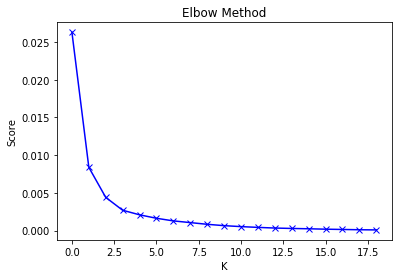

In [21]:
from sklearn.cluster import KMeans
from sklearn import cluster

# dimensionality reduction using feature clustering
agglo = cluster.FeatureAgglomeration(n_clusters=2)
features = agglo.fit_transform(X)

score = []

K = 20

# perform k-means for values of k between 1,20
for i in range(1,K):
    model = KMeans(i).fit(features)
    cluster_labels = model.fit_predict(features)
    score.append(model.inertia_)

# plot error score
plt.plot(score, 'bx-') 
plt.xlabel('K') 
plt.ylabel('Score') 
plt.title('Elbow Method') 
plt.show() 

Using the elbow method, the ideal value of K = 3.


Mean voter turnout = 0.517

Cluster 0: 
 ['Alaska' 'Arkansas' 'Colorado' 'Connecticut' 'Idaho' 'Iowa' 'Kansas'
 'Louisiana' 'Maine' 'Massachusetts' 'Michigan' 'Missouri' 'New Hampshire'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Rhode Island'
 'South Dakota' 'Tennessee' 'Texas' 'Vermont' 'West Virginia' 'Wisconsin'
 'Wyoming'] 
Mean voter turnout = 0.520

Cluster 1: 
 ['Arizona' 'California' 'Florida' 'Georgia' 'Hawaii' 'Illinois' 'Indiana'
 'Maryland' 'Nevada' 'New Mexico' 'Utah'] 
Mean voter turnout = 0.498

Cluster 2: 
 ['Alabama' 'Delaware' 'Kentucky' 'Minnesota' 'Mississippi' 'Montana'
 'Nebraska' 'New Jersey' 'New York' 'Oregon' 'Pennsylvania'
 'South Carolina' 'Virginia' 'Washington'] 
Mean voter turnout = 0.528


Silhouette Score of k-means clustering = 0.545


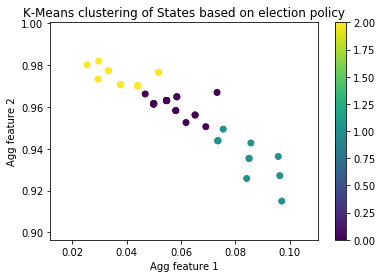

In [26]:
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# dimensionality reduction using feature clustering
agglo = cluster.FeatureAgglomeration(n_clusters=2)
features = agglo.fit_transform(X)

# cluster data using kmeans
K = 3
model = KMeans(n_clusters=K).fit(features)

print("\nMean voter turnout = {:2.3f}".format(np.mean(Y)))

# print state->cluster mapping
clusters = model.labels_.reshape(50,1)
states_clusters = np.hstack((clusters, states, Y))
for i in range(0,K):
    cluster = states_clusters[states_clusters[:,0] == i]
    print("\nCluster " + str(i) + ": \n", cluster[:,1], "\nMean voter turnout = {:2.3f}".format(np.mean(cluster[:,2])))
    
# compute silhouette score
print("\n\nSilhouette Score of k-means clustering = {:2.3f}".format(metrics.silhouette_score(features, model.labels_, metric='euclidean')))

# plot graph
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import plot

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(data=go.Choropleth(
    locations=df['code'],
    text=df['state'],
    z=clusters.ravel(), # Data to be color-coded
    locationmode='USA-states',
    colorscale='Greens',
))

fig.update_layout(
    title_text='K-Means 3-Clustering based on State Election Policy',
    geo_scope='usa'
)

plot(fig, filename='kmeans.html')

plt.title("K-Means clustering of States based on election policy")
plt.xlabel('Agg feature 1')
plt.ylabel('Agg feature 2')
p = plt.scatter(features[:, 0], features[:, 1], c=model.labels_.astype(float))
plt.colorbar(p)
plt.show()

### Feature Extraction

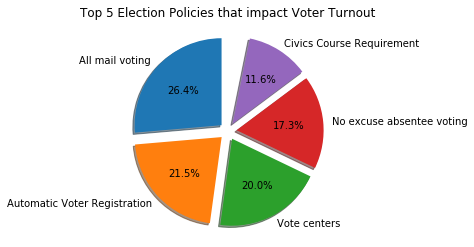

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert Y to classes based on threshold
threshold = np.mean(Y)
labels = Y.copy()
labels[labels < threshold] = 0 # low turnout
labels[labels >= threshold] = 1 # high turnout

# Visualize feature importance
K = 5
explode = np.zeros(K)
explode[:K] = 0.1
model = SelectKBest(chi2, k=K)
model.fit_transform(X, labels)
indices = np.argsort(model.scores_)[::-1]
top_features = []
for i in indices:
    top_features.append(feature_names[i])

fig = plt.figure()
fig.clf()
ax = fig.add_subplot(111)
plt.title("Top 5 Election Policies that impact Voter Turnout")
plt.pie(model.scores_[indices[range(K)]], labels=top_features[:K], autopct='%1.1f%%', shadow=True, startangle=90, explode=explode)
plt.show()

### Conclusion